# Приступая к работе

### Путь к данным

In [1]:
TRAIN_DATASET_PATH = 'data/course_project_train.csv'
TEST_DATASET_PATH = 'data/course_project_test.csv'

### Подключение библиотек

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from scipy.stats import shapiro, mannwhitneyu, chi2_contingency
import catboost as catb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Загрузка данных

In [3]:
df = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

# EDA
Разведочный анализ данных

In [4]:
# Копия тренировочного датасета для экспериметов
eda_df = df.copy()

## Обработка пропусков

### Признаки с пропусками

In [5]:
def features_with_missing_values(df):
    # Количество наблюдений в датасете
    observations_count = df.shape[0]
    
    # Найдем все признаки с пропущенными значениями
    cols_with_missing = [ col for col in df.columns if df[col].count() < observations_count ]
    
    # Вернем их
    return cols_with_missing

# Признаки с пропусками в тренировоном и тестовом датасете
print(features_with_missing_values(df))
print(features_with_missing_values(test))

['Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']
['Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']


Как можно заметить, одни и те же признаки имеют пропущенные значение в тренировочном и тестовом датасете

Отметим отсутствующие значения в новых бинарных признаках

In [6]:
for col in features_with_missing_values(eda_df):
    eda_df[col + '_was_missing'] = eda_df[col].isnull()

### Корреляция признаков

<AxesSubplot:>

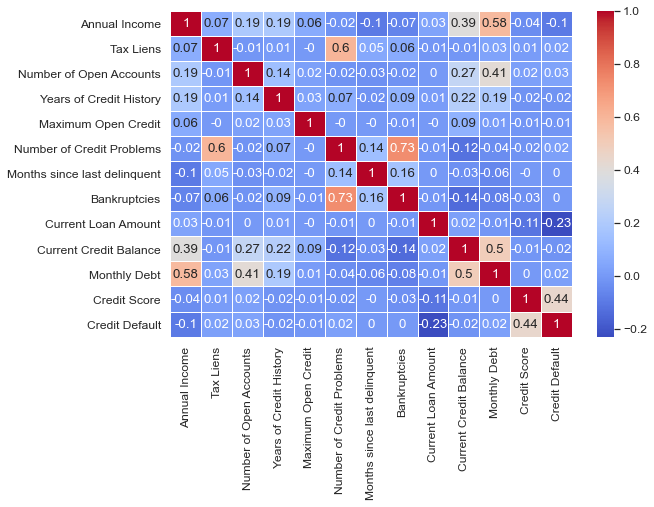

In [7]:
df_corr = np.round(df.corr(), 2)

plt.figure(figsize = (9,6))
sns.set(font_scale=1.1)
sns.heatmap(df_corr, annot=True, linewidths=.5, cmap='coolwarm')

Так как Annual Income коррелирует с Monthly Debt, его пропущенные значения можно заполнить через Montly Debt. То же самое касается Bankruptcies и Number of Credit Problems. Для этого обучим модель линейной регрессии предсказывать X через Y

In [8]:
def imput_by_correlating(df, target, correlating):
    # Создадим DataFrame c кореллирующем и целевым признаком
    corr_df = pd.DataFrame({
        correlating: df[correlating],
        target: df[target]
    })
    
    # Удалим наблюдения с пропусками
    corr_df.dropna(inplace=True)
    
    # Поделим датафрейм на тот, что с правильным ответом и без
    X = corr_df.drop(columns=target)
    y = corr_df[target]
    
    # Создадим и обучим модель
    lr = LinearRegression()
    lr.fit(X, y)
    
    # Предскажем весь столдец целевого признака
    predicted_target = lr.predict(
        pd.DataFrame({ correlating: df[correlating]})
    )
    
    # Заполним пропуски предсказаниями
    df[target].fillna(pd.Series(predicted_target), inplace=True)

In [9]:
imput_by_correlating(eda_df, "Annual Income", "Monthly Debt")
imput_by_correlating(eda_df, "Bankruptcies", "Number of Credit Problems")

### Распределение кредитного рейтинга

<AxesSubplot:xlabel='Credit Default', ylabel='Credit Score'>

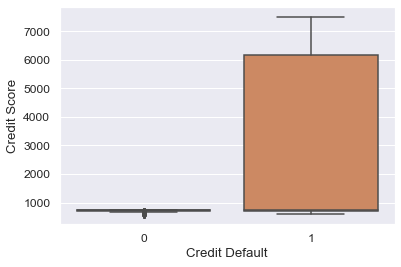

In [10]:
# plt.hist(df["Credit Score"], bins=30)
# plt.scatter(df["Credit Score"], df["Credit Default"])
# plt.show()
sns.boxplot(x=df["Credit Default"], y=df["Credit Score"])

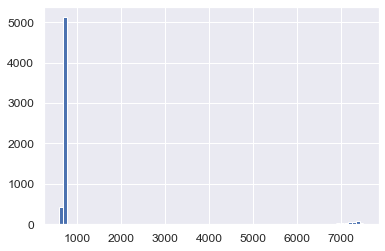

In [11]:
_ = plt.hist(df["Credit Score"], bins="sqrt")

Вычислим медианы Credit Score для обоих значений Credit Default

In [12]:
credit_default_median = eda_df.groupby(["Credit Default"])["Credit Score"].agg("median")
credit_default_median

Credit Default
0    732.0
1    730.5
Name: Credit Score, dtype: float64

Как можно заметить, обе медианы очень близки и не уходят в четырех значные числа. Очевидно, есть выбросы. На самом деле это не выбросы, а большие должники, поэтому их мы убирать не будем. Давайте заполним пропущенные значения в Credit Score этими медианами

In [13]:
eda_df["Credit Score"].fillna(eda_df["Credit Default"].map(credit_default_median), inplace=True)

### Заполняем остальные пропущенные значение

#### Years in current job

In [14]:
eda_df["Years in current job"].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

Будем считать, что если данные отсутствуют, клиент банка не работает. Заполним значением '< 1 year'

In [15]:
eda_df["Years in current job"].fillna("< 1 year", inplace=True)

#### Months since last delinquent

Тут я никакой закономерности не нашел. Заполню медианой

In [16]:
eda_df["Months since last delinquent"].fillna( \
    eda_df["Months since last delinquent"].median(), inplace=True)

Убедимся, что больше пропущенных значений нет

In [17]:
features_with_missing_values(eda_df)

[]

## Статистические гипотизы

#### Из всех количественных признаков, какие распределены нормально?
Выведем список всех количественных признаков

In [18]:
quantitative_dtypes = [ 'float64', 'float32', 'float16' ]
quantitative_features = [ col for col in eda_df.columns if eda_df[col].dtype in quantitative_dtypes]
quantitative_features

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

Для проверки распределения на нормальность будем использовать критерий Шапиро-Уилка

In [19]:
def check_shapiro(df):
    for feature in quantitative_features:
        stat, p = shapiro(df[feature])
        alpha = 0.05
        if p > alpha:
            print(f"✅ {feature} похоже, распределен нормально. p = {p}")
        else:
            print(f"❌ {feature} распределен не нормально. p = {p}")

In [20]:
check_shapiro(eda_df)

❌ Annual Income распределен не нормально. p = 0.0
❌ Tax Liens распределен не нормально. p = 0.0
❌ Number of Open Accounts распределен не нормально. p = 0.0
❌ Years of Credit History распределен не нормально. p = 0.0
❌ Maximum Open Credit распределен не нормально. p = 0.0
❌ Number of Credit Problems распределен не нормально. p = 0.0
❌ Months since last delinquent распределен не нормально. p = 0.0
❌ Bankruptcies распределен не нормально. p = 0.0
❌ Current Loan Amount распределен не нормально. p = 0.0
❌ Current Credit Balance распределен не нормально. p = 0.0
❌ Monthly Debt распределен не нормально. p = 0.0
❌ Credit Score распределен не нормально. p = 0.0


c:\users\blaze\scoop\apps\python\3.9.1\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Попробуем логарифмизировать эти признаки и еще раз проверим на нормальность

In [21]:
eda_log_df = eda_df.copy()

for feature in quantitative_features:
    eda_log_df[feature] = np.log1p(eda_log_df[feature])

check_shapiro(eda_log_df)

❌ Annual Income распределен не нормально. p = 3.375227564666221e-18
❌ Tax Liens распределен не нормально. p = 0.0
❌ Number of Open Accounts распределен не нормально. p = 3.89771478979336e-20
❌ Years of Credit History распределен не нормально. p = 7.846205107853166e-07
❌ Maximum Open Credit распределен не нормально. p = 0.0
❌ Number of Credit Problems распределен не нормально. p = 0.0
❌ Months since last delinquent распределен не нормально. p = 0.0
❌ Bankruptcies распределен не нормально. p = 0.0
❌ Current Loan Amount распределен не нормально. p = 0.0
❌ Current Credit Balance распределен не нормально. p = 0.0
❌ Monthly Debt распределен не нормально. p = 0.0
❌ Credit Score распределен не нормально. p = 0.0


Ни один признак не распределен нормально. Будем использовать непараметрические критерии.
#### Есть ли отличия в распределениях признаков на train и test?
Давайте проверим, есть ли отличия в распределениях признаков на train и test используя критерий U-Манна-Уитни

In [22]:
def check_mannwhitneyu(df_a, df_b):
    for feature in quantitative_features:
        stat, p = mannwhitneyu(df_a[feature].dropna(), df_b[feature].dropna(), alternative='two-sided')
        alpha = 0.05
        if p > alpha:
            print(f"✅ {feature} похоже, равен по мат. ожиданию. p = {p}")
        else:
            print(f"❌ {feature} не равен по мат. ожиданию. p = {p}")

In [23]:
check_mannwhitneyu(eda_df, test)

✅ Annual Income похоже, равен по мат. ожиданию. p = 0.0993412119415356
✅ Tax Liens похоже, равен по мат. ожиданию. p = 0.1967372056760731
✅ Number of Open Accounts похоже, равен по мат. ожиданию. p = 0.4428527435772891
✅ Years of Credit History похоже, равен по мат. ожиданию. p = 0.7773891904970164
✅ Maximum Open Credit похоже, равен по мат. ожиданию. p = 0.7664441986829786
✅ Number of Credit Problems похоже, равен по мат. ожиданию. p = 0.28391545104752514
❌ Months since last delinquent не равен по мат. ожиданию. p = 0.026812927132806655
✅ Bankruptcies похоже, равен по мат. ожиданию. p = 0.05619958034738773
✅ Current Loan Amount похоже, равен по мат. ожиданию. p = 0.24634871937364144
✅ Current Credit Balance похоже, равен по мат. ожиданию. p = 0.7432294982728612
✅ Monthly Debt похоже, равен по мат. ожиданию. p = 0.48739046661346275
✅ Credit Score похоже, равен по мат. ожиданию. p = 0.8349968915750885


#### Сравним распределения количественных признаков в разрезе целевой переменной
Используем критерий U-Манна-Уитни

- Нулевая гипотеза: распределения одинаковы (нет вляния на целевую переменную)
- Альтернативная гипотеза: есть зависимость между этим признаком и целевой переменной, он ценен для модели

In [24]:
# p_values = pd.Series(dtype='float64')
for feature in quantitative_features:
    cd_0 = eda_df.loc[(eda_df["Credit Default"] == 0), feature]
    cd_1 = eda_df.loc[(eda_df["Credit Default"] == 1), feature]
    stat, p = mannwhitneyu(cd_0, cd_1)
    alpha = 0.05
    if p > alpha:
        print(f"❌ {feature} наименее значимый признак, можно удалить")
    else:
        print(f"✅ {feature} значимый признак, оставить")
        # p_values[feature] = p

✅ Annual Income значимый признак, оставить
✅ Tax Liens значимый признак, оставить
✅ Number of Open Accounts значимый признак, оставить
✅ Years of Credit History значимый признак, оставить
✅ Maximum Open Credit значимый признак, оставить
❌ Number of Credit Problems наименее значимый признак, можно удалить
❌ Months since last delinquent наименее значимый признак, можно удалить
❌ Bankruptcies наименее значимый признак, можно удалить
✅ Current Loan Amount значимый признак, оставить
❌ Current Credit Balance наименее значимый признак, можно удалить
✅ Monthly Debt значимый признак, оставить
✅ Credit Score значимый признак, оставить


От наименее значимый давайте как раз и избавимся

In [25]:
weak_features = [
    "Number of Credit Problems",
    "Months since last delinquent",
    "Bankruptcies",
    "Current Credit Balance"
]

try:
    eda_df.drop(columns=weak_features, inplace=True)
except KeyError:
    pass

quantitative_features = [ f for f in quantitative_features if f not in weak_features ]

#### Сравним попарно доли целевой переменной в категориях признака Home Ownership

<AxesSubplot:xlabel='Home Ownership', ylabel='count'>

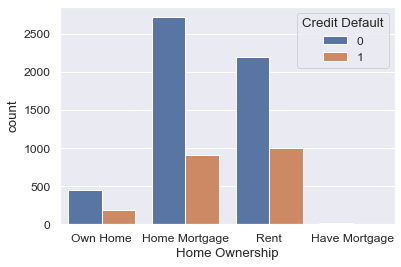

In [26]:
sns.countplot(x="Home Ownership", hue="Credit Default", data=eda_df)

Выведем процентное соотношение категории Home Ownership в разрезе целевой переменной

In [27]:
home_ownership_cd_0 = eda_df.loc[(eda_df["Credit Default"] == 0), "Home Ownership"].value_counts()
home_ownership_cd_1 = eda_df.loc[(eda_df["Credit Default"] == 1), "Home Ownership"].value_counts()
home_ownership_aspect = pd.Series(dtype='float64')

for cat in home_ownership_cd_0.index:
    aspect = (home_ownership_cd_1[cat] / home_ownership_cd_0[cat]) * 100
    home_ownership_aspect[cat] = aspect
    print(f"{cat} {aspect}%")

print()

similar_shares = {}

for cat_a in home_ownership_aspect.index:
    for cat_b in home_ownership_aspect.index:
        if(cat_a == cat_b):
            continue
            
        # Уберем дубликаты
        try:
            if(similar_shares[cat_a] == cat_b):
                continue
        except KeyError:
            pass
        try:
            if(similar_shares[cat_b] == cat_a):
                    continue
        except KeyError:
            pass
        
        # Поделим числа. Если результат деления близок к 1, то доли схожи
        div = abs(home_ownership_aspect[cat_a] / home_ownership_aspect[cat_b])
        if(abs(1 - div) < 0.2):
            similar_shares[cat_a] = cat_b

for cat in similar_shares:
    print(f"Доли {cat} схожи с {similar_shares[cat]}")

Home Mortgage 33.6640940830577%
Rent 45.57019536574284%
Own Home 42.1978021978022%
Have Mortgage 20.0%

Доли Rent схожи с Own Home


**Наблюдение**

Как можно заметить, Rent и Own Home на первый взгляд, имеют схожие доли в разрезе целевой переменной. Если это так, эти две категории можно объединить в одну

**Гипотеза**
- Нулевая гипотеза: две частоты одинаково влияют на целевую переменную
- Альтернативная гипотеза: отклонения в частотах статистически значимы
- Критерий: Хи-квадрат Пирсона
- Уровень значимости  𝛼 = 0.05 
- Критическая область: двухсторонняя

Давайте посмотрим, сколько приходится значений каждой категории на обе значения целевой переменной. Для этого составим сводную таблицу. В качестве списка значений можно использовать любой признак, я использовал Tax Liens

In [28]:
home_ownership_target = df.loc[df['Home Ownership'].isin(['Rent', 'Own Home']),
                               ['Tax Liens', 'Home Ownership', 'Credit Default']]
home_ownership_target_pivot = home_ownership_target.pivot_table(
    index='Home Ownership',
    values='Tax Liens',
    columns='Credit Default',
    aggfunc='count')
home_ownership_target_pivot

Credit Default,0,1
Home Ownership,,
Own Home,455,192
Rent,2201,1003


Проверим нашу гипотезу

In [29]:
chi2, p, dof, expected = chi2_contingency(home_ownership_target_pivot, correction=False)
print(p)
print(p > 0.05)

0.41388761719718237
True


P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории Own Home и Rent одинаково влияют на целевую переменную и их можно объединить в одну категорию. Давайте так и сделаем

In [30]:
eda_df.loc[eda_df['Home Ownership'] == 'Own Home', 'Home Ownership'] = 'Rent or Own Home'
eda_df.loc[eda_df['Home Ownership'] == 'Rent', 'Home Ownership'] = 'Rent or Own Home'
eda_df['Home Ownership'].unique()

array(['Rent or Own Home', 'Home Mortgage', 'Have Mortgage'], dtype=object)

#### Сравним доли целевой переменной в категориях признака Term

Насколько сильный признак Term для модели? Используем критерий Хи-квадрат Пирсона. Создадим сводную таблицу, как делали это выше

In [31]:
term_target_pivot = eda_df.pivot_table(
    index='Term',
    # В values можно любой признак подставить
    values='Tax Liens',
    columns='Credit Default',
    aggfunc='count')
term_target_pivot

Credit Default,0,1
Term,,
Long Term,1128,816
Short Term,4259,1297


Проверим гипотезу
- Нулевая гипотеза: признак Term не вляет на целевую переменную
- Альтернативная гипотеза: Term является сильным признаком

In [32]:
chi2, p, dof, expected = chi2_contingency(term_target_pivot, correction=False)
print(p)
print(p > 0.05)

1.1519373940439208e-55
False


P-value получилось меньше выбранного уровня значимости, соответственно у нас есть основания для отвержения нулевой гипотезы и можно допустить, что Term является сильным признаком для модели

## Обработка выбросов

In [33]:
eda_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Current Loan Amount,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.367881e+06,0.030133,11.130933,18.317467,9.451537e+05,1.187318e+07,18314.454133,1063.979133,0.281733
std,7.865447e+05,0.271604,4.908924,7.041946,1.602622e+07,3.192612e+07,11926.764673,1438.312319,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,1.124200e+04,0.000000,585.000000,0.000000
25%,8.767305e+05,0.000000,8.000000,13.500000,2.792295e+05,1.801690e+05,10067.500000,718.000000,0.000000
50%,1.211216e+06,0.000000,10.000000,17.000000,4.781590e+05,3.095730e+05,16076.500000,732.000000,0.000000
75%,1.630654e+06,0.000000,14.000000,21.800000,7.935015e+05,5.198820e+05,23818.000000,740.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,1.000000e+08,136679.000000,7510.000000,1.000000


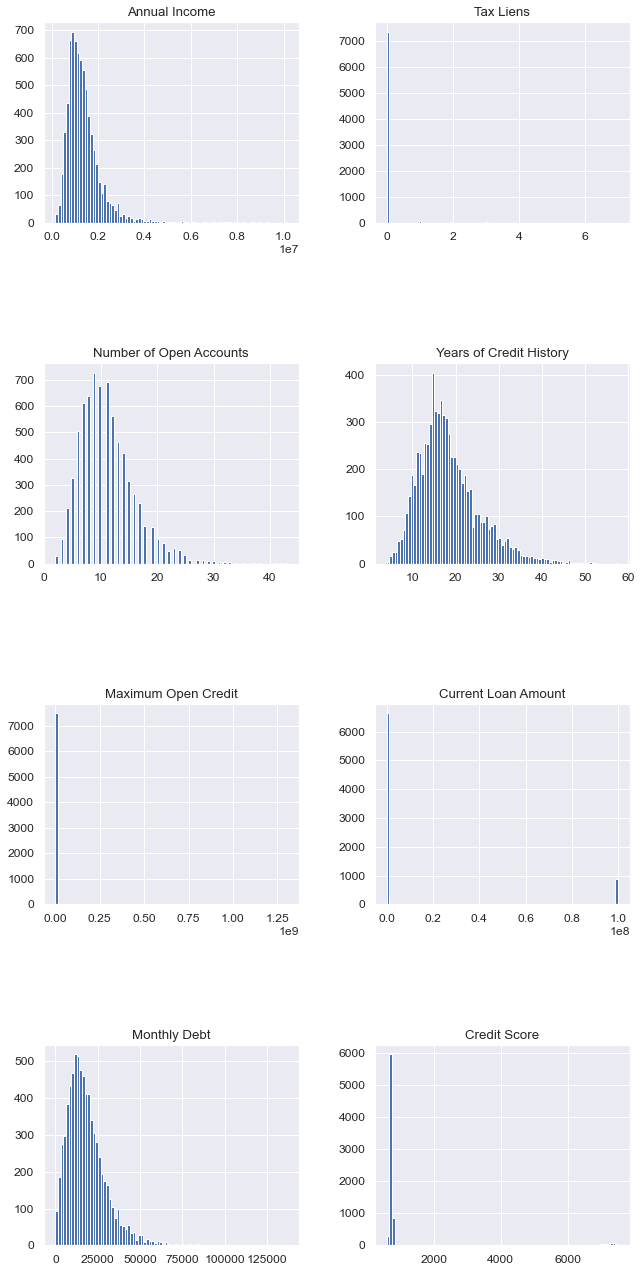

In [34]:
fig, ax = plt.subplots(nrows=4, ncols=2)

fig.set_size_inches(10.5, 22.5)
fig.subplots_adjust(wspace=0.3, hspace=0.7)

def feature_hist_to_ax(feature, row, col):
    ax[row][col].set_title(feature)
    ax[row][col].hist(eda_df[feature], bins="sqrt")

feature_hist_to_ax("Annual Income", 0, 0)
feature_hist_to_ax("Tax Liens", 0, 1)
feature_hist_to_ax("Number of Open Accounts", 1, 0)
feature_hist_to_ax("Years of Credit History", 1, 1)
feature_hist_to_ax("Maximum Open Credit", 2, 0)
feature_hist_to_ax("Current Loan Amount", 2, 1)
feature_hist_to_ax("Monthly Debt", 3, 0)
feature_hist_to_ax("Credit Score", 3, 1)

#### Credit Score

In [35]:
eda_df['Credit Score_outlier'] = 0
eda_df.loc[(eda_df['Credit Score'] > 1000), 'Credit Score_outlier'] = 1

## Новые признаки

#### Net Debt

Чистый долг. Признак Current Credit Balance удален

#### Loan repayment period from income

Период выплаты кредита из дохода

In [ ]:
eda_df["Loan repayment period from income"] = eda_df["Current Loan Amount"] - eda_df["Annual Income"]

### Строковые признаки

Выведем все строковые признаки

In [37]:
print([ col for col in eda_df.columns if eda_df[col].dtype == 'O' ])

['Home Ownership', 'Years in current job', 'Purpose', 'Term']


Модели работают только с числовыми признаками. Переведем их в числа

#### Home Ownership

In [38]:
eda_df["Home Ownership"].unique()

array(['Rent or Own Home', 'Home Mortgage', 'Have Mortgage'], dtype=object)

Этот признак не числовой, а категориальный. Лучшая стратегия это перевести его в дамми признаки

In [39]:
home_ownership_dummies = pd.get_dummies(eda_df["Home Ownership"], prefix="Home Ownership")
eda_df = pd.concat([eda_df, home_ownership_dummies], axis=1)

#### Years in current job

In [40]:
eda_df["Years in current job"].unique()

array(['< 1 year', '10+ years', '8 years', '6 years', '7 years',
       '5 years', '1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

Этот признак вещественный. Давайте переведем его в числа, заодно укажем оптимальный тип

In [41]:
eda_df["Years in current job"] = eda_df["Years in current job"].map({
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0
    }).astype(np.int8)

#### Purpose

In [42]:
eda_df["Purpose"].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

Это тоже категориальный признак. Заменим его на дамми переменные

In [43]:
purpose_dummies = pd.get_dummies(eda_df["Purpose"], prefix="Purpose")
eda_df = pd.concat([eda_df, purpose_dummies], axis=1)

#### Term

In [44]:
eda_df["Term"].unique()

array(['Short Term', 'Long Term'], dtype=object)

Это бинарный признак. Его можно заменить на числа

In [45]:
eda_df["Is Long Term"] = eda_df["Term"].map({
        'Short Term': 0,
        'Long Term': 1
    }).astype(np.int8)

## Отбор признаков

Мы добавили к строковым признакам их числовые эквиваленты, но строковые признаки все еще остались. Давайте их уберем

In [46]:
str_features = [ col for col in eda_df.columns if eda_df[col].dtype == 'O' ]
eda_df.drop(columns=str_features, inplace=True)

## Обучение

Обучим модель градиентного бустинга, посмотим важность признаков и отбросим самые неважные

In [47]:
# Признаки
eda_X = eda_df.drop("Credit Default", axis=1)

# Целевая переменная
eda_y = eda_df["Credit Default"]

# Разделение на тренировочную и валидационную выборку
eda_X_train, eda_X_valid, eda_y_train, eda_y_valid = \
    train_test_split(eda_X, eda_y, test_size=0.3, random_state=42)

# Обучение

eda_model = GradientBoostingClassifier(criterion='mse',
                                  max_depth=3,
                                  min_samples_leaf=100,
                                  random_state=42,
                                  n_estimators=1050)
eda_model.fit(eda_X_train, eda_y_train)

GradientBoostingClassifier(criterion='mse', min_samples_leaf=100,
                           n_estimators=1050, random_state=42)

### Оценка качества модели

In [48]:
eda_train_pred = eda_model.predict(eda_X_train)
eda_valid_pred = eda_model.predict(eda_X_valid)

In [49]:
def check_precision_recall(y, pred):
    # Матрица ошибок
    conf_matrix = confusion_matrix(y, pred)

    TP = conf_matrix[1][1]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


def check_metrics(y_train, train_pred, y_valid, valid_pred):
    print("-- Тренировочная выборка -- ")
    print(f"F1: {f1_score(y_train, train_pred)}")
    check_precision_recall(y_train, train_pred)
    print("\n-- Валидационная выборка -- ")
    print(f"F1: {f1_score(y_valid, valid_pred)}")
    check_precision_recall(y_valid, valid_pred)

In [50]:
check_metrics(eda_y_train, eda_train_pred, eda_y_valid, eda_valid_pred)

-- Тренировочная выборка -- 
F1: 0.8648233486943164
Precision: 0.979982593559617
Recall: 0.7738831615120275

-- Валидационная выборка -- 
F1: 0.6449864498644986
Precision: 0.7951002227171492
Recall: 0.5425531914893617


### Важность признаков

In [51]:
feature_importances = pd.DataFrame(zip(eda_X_train.columns, eda_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
8,Credit Score,0.387930
14,Credit Score_outlier,0.157062
13,Credit Score_was_missing,0.094699
6,Current Loan Amount,0.082651
9,Annual Income_was_missing,0.045971
7,Monthly Debt,0.042065
15,Loan repayment period from income,0.041262
5,Maximum Open Credit,0.036442
0,Annual Income,0.032315
4,Years of Credit History,0.029323


Отбросим ненужные признаки. Дамми признаки пока оставим

In [52]:
unnecessary_features = [
    'Tax Liens',
    'Bankruptcies_was_missing'
]
eda_df.drop(columns=unnecessary_features, inplace=True)

# Предобработка данных

CorrelationImputer

In [55]:
class CorrelationImputer:
    
    def __init__(self):
        self.lr = LinearRegression()
        self.correlating = None
        self.target = None
        
    def fit(self, df, target, correlating):
        # Запомним переменные
        self.correlating = correlating
        self.target = target
        
        # Создадим DataFrame c кореллирующем и целевым признаком
        corr_df = pd.DataFrame({
            correlating: df[correlating],
            target: df[target]
        })

        # Удалим наблюдения с пропусками
        corr_df.dropna(inplace=True)

        # Поделим датафрейм на тот, что с правильным ответом и без
        X = corr_df.drop(columns=target)
        y = corr_df[target]
    
        # Обучим модель
        self.lr.fit(X, y)
    
    def transform(self, df):
        # Предскажем весь столдец целевого признака
        predicted_target = self.lr.predict(
            pd.DataFrame({ self.correlating: df[self.correlating]})
        )

        # Заполним пропуски предсказаниями
        new_df = df.copy()
        new_df[self.target].fillna(pd.Series(predicted_target), inplace=True)
        return new_df

DataPipeline

In [56]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
        self.annual_income_imputer = CorrelationImputer()
        self.recovered_credit_score = None
        
        self.unnecessary_features = [
            'Tax Liens',
            'Bankruptcies_was_missing'
        ]
        
        self.weak_features = [
            "Number of Credit Problems",
            "Months since last delinquent",
            "Bankruptcies",
            "Current Credit Balance"
        ]
        
        self.str_features = [
            "Term"
        ]
        
        self.categorial_features = [
            'Home Ownership',
            'Purpose'
        ]
        
    def fit(self, X, y):
        """Сохранение статистик"""
        
        self.annual_income_imputer.fit(X, "Annual Income", "Monthly Debt")
        
        df_with_credit_default = X.copy()
        df_with_credit_default["Credit Default"] = y
        
        credit_score_median = df_with_credit_default \
            .groupby(["Credit Default"])["Credit Score"].agg("median")
        
        self.recovered_credit_score = df["Credit Default"].map(credit_score_median);
        
    def transform(self, df):
        """Трансформация данных"""
        
        # Пропущенные значения
        
        for col in features_with_missing_values(df):
            df[col + '_was_missing'] = df[col].isnull()
            
        df = self.annual_income_imputer.transform(df)
        
        df["Credit Score"].fillna(self.recovered_credit_score, inplace=True)
        
        df["Years in current job"].fillna("< 1 year", inplace=True)
        
        # Выбросы
        
        df['Credit Score_outlier'] = 0
        df.loc[(df['Credit Score'] > 1000), 'Credit Score_outlier'] = 1
        
        # Генерация новых признаков
        
        df["Loan repayment period from income"] = df["Current Loan Amount"] - df["Annual Income"]
        
        df.loc[df['Home Ownership'] == 'Own Home', 'Home Ownership'] = 'Rent or Own Home'
        df.loc[df['Home Ownership'] == 'Rent', 'Home Ownership'] = 'Rent or Own Home'
        
        df["Years in current job"] = df["Years in current job"].map({
            '10+ years': 10,
            '9 years': 9,
            '8 years': 8,
            '7 years': 7,
            '6 years': 6,
            '5 years': 5,
            '4 years': 4,
            '3 years': 3,
            '2 years': 2,
            '1 year': 1,
            '< 1 year': 0
        }).astype(np.int8)
        
        df["Is Long Term"] = df["Term"].map({
            'Short Term': 0,
            'Long Term': 1
        }).astype(np.int8)
        
        # Отбор признаков
        
        df.drop(columns=self.str_features, inplace=True)
        df.drop(columns=self.weak_features, inplace=True)
        df.drop(columns=self.unnecessary_features, inplace=True)
        
        # Преобразование признаков для Catboost
        
        for feature in self.categorial_features:
            df[feature] = pd.Categorical(df[feature])
        
        return df

In [57]:
# Признаки
X = df.drop("Credit Default", axis=1)

# Целевая переменная
y = eda_df["Credit Default"]

# Разделение на тренировочную и валидационную выборку
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Предобработка данных
pipe = DataPipeline()
pipe.fit(X_train, y_train)
X_train = pipe.transform(X_train)
X_valid = pipe.transform(X_valid)

<ipython-input-56-f0d61c1b0803>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_was_missing'] = df[col].isnull()
<ipython-input-56-f0d61c1b0803>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_was_missing'] = df[col].isnull()


# Подбор гиперпараметров модели

Подбор по сетке длится очень долго. Я закоментировал код, чтобы тетрадка быстрее отрабатывала

In [ ]:
params = {
    'learning_rate': [0.05, 0.1, 0.5],
    'depth':[4, 6, 8]
}
model_hp = catb.CatBoostClassifier(n_estimators=1000,
                                     custom_loss=['F1'],
                                     silent=True,
                                     random_state=21)

# train_pool = catb.Pool(data=X_train, label=y_train, cat_features=pipe.categorial_features)
#
#grid_search_results = model_hp.grid_search(params, train_pool, cv=5, stratified=True,
#                                             verbose=False, plot=False)
#
#grid_search_results['params']

# {'depth': 6, 'learning_rate': 0.1}

# Обучение

В этот раз для обучения будем использовать CatBoost. Я специально не стал генерировать дамми признаки, потому что Catboost их не любит. Вместо этого мы скормим ему список всех категориальных признаков и он сам разберется с ними

In [ ]:
model = catb.CatBoostClassifier(
    learning_rate=0.1,
    depth=3,
    n_estimators=1000,
    silent=True, random_state=21, cat_features=pipe.categorial_features)
model.fit(X_train, y_train)

# Предсказание

In [ ]:
train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)

### Оценка качества модели на тренировочной и валидационной выборке

In [ ]:
check_metrics(y_train, train_pred, y_valid, valid_pred)

ROC кривая

In [ ]:
fpr, tpr, _ = roc_curve(y_valid, valid_pred)
plt.plot(fpr,tpr)

## Предсказание на тесте

Подготовим данные

In [ ]:
test_ids = [ i for i in range(test.shape[0]) ]
test_copy = test.copy()
test_copy = pipe.transform(test_copy)

Предскажем и сохраним в файл

In [ ]:
test_pred = model.predict(test_copy)
test_pred_output = pd.DataFrame({"Id": test_ids, "Credit Default": test_pred})
test_pred_output.to_csv("DmitryKozichev_predictions.csv", index=False)